In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
gpt = pd.concat([
    pd.read_csv("/Volumes/methlab/Students/Jonathan/data_preprocessed/gpt_features/v5features/ADReSS_manual_transcripts_train/values.csv"),
    pd.read_csv("/Volumes/methlab/Students/Jonathan/data_preprocessed/gpt_features/v5features/ADReSS_manual_transcripts_test/values.csv"),
    ])[['sample_name', 'Word-Finding Difficulties (Anomia)']].rename(columns={'Word-Finding Difficulties (Anomia)': 'gpt'})
gpt

,sample_name,gpt
0,S096,5.0
1,S118,6.0
2,S116,4.0
3,S111,6.0
4,S124,2.0
...,...,...
43,S203,4.0
44,S204,2.0
45,S205,2.0
46,S206,2.0


In [3]:
explanations = pd.concat([
    pd.read_csv("/Volumes/methlab/Students/Jonathan/data_preprocessed/gpt_features/v5features/ADReSS_manual_transcripts_train/explanations.csv"),
    pd.read_csv("/Volumes/methlab/Students/Jonathan/data_preprocessed/gpt_features/v5features/ADReSS_manual_transcripts_test/explanations.csv"),
    ])[['sample_name', 'Word-Finding Difficulties (Anomia)_explanation']]
explanations

sample_name     Word-Finding Difficulties (Anomia)_explanation

[156 rows x 2 columns]

In [4]:
from config.constants import Constants

constants = Constants()

manual = pd.read_csv(os.path.join(constants.RESOURCES_DIR, "manual_ratings_word_finding_processed.csv"))
manual#.manual_rating.value_counts()

,sample_name,Antonia,Dafna
0,S001,6.0,3.0
1,S002,4.0,2.0
2,S003,6.0,2.0
3,S004,5.0,2.0
4,S005,6.0,4.0
...,...,...,...
151,S203,2.0,6.0
152,S204,3.0,1.0
153,S205,3.0,5.0
154,S206,7.0,2.0


In [5]:
combined = manual.merge(gpt, on="sample_name", how="outer")

combined

,sample_name,Antonia,Dafna,gpt
0,S001,6.0,3.0,3.0
1,S002,4.0,2.0,2.0
2,S003,6.0,2.0,3.0
3,S004,5.0,2.0,2.0
4,S005,6.0,4.0,3.0
...,...,...,...,...
151,S203,2.0,6.0,4.0
152,S204,3.0,1.0,2.0
153,S205,3.0,5.0,2.0
154,S206,7.0,2.0,2.0


In [6]:
# Note that the two raters used slightly different instructions (due to some unclarities, it was updated after Antonia, to make it more clear for Dafna)
# While the general instructions where kept the same, the rating values were inversed, i.e. for Antonia, 1 is best, 7 is worse, for Dafna the opposite
# The optimal correlation will thus be -1

combined[['Antonia', 'Dafna', 'gpt']].corr(method='spearman')

,Antonia,Dafna,gpt
Antonia,1.000000,-0.596384,-0.432751
Dafna,-0.596384,1.000000,0.581016
gpt,-0.432751,0.581016,1.000000


array([[<Axes: title={'center': 'Antonia'}>,
        <Axes: title={'center': 'Dafna'}>],
       [<Axes: title={'center': 'gpt'}>, <Axes: >]], dtype=object)

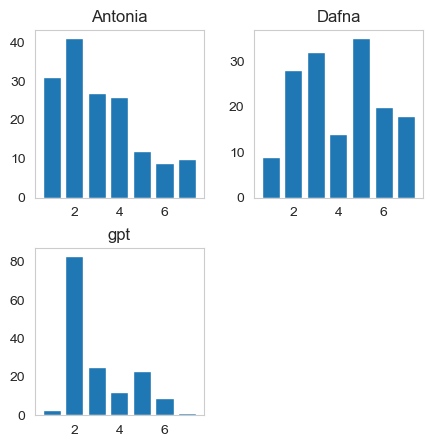

In [7]:
import matplotlib.pyplot as plt
combined[['Antonia', 'Dafna', 'gpt']].hist(bins=np.arange(8)+0.5, grid=False, rwidth=0.8, figsize=(5,5))

Text(0, 0.5, 'GPT')

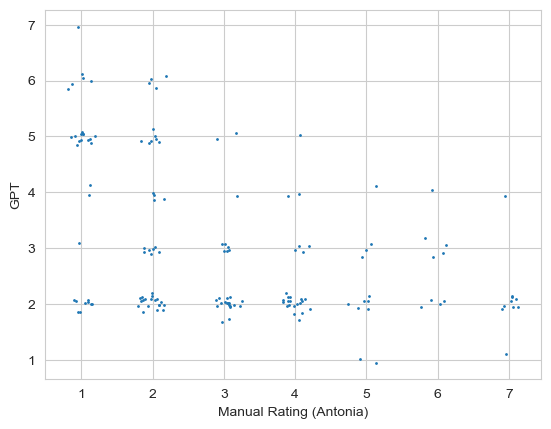

In [8]:
!
def jitter(values):
    return values + np.random.normal(0,0.1,values.shape)


plt.scatter(jitter(combined.Antonia), jitter(combined.gpt), s=1)
plt.xlabel("Manual Rating (Antonia)")
plt.ylabel("GPT")

In [9]:
counts = combined[['Antonia', 'gpt', 'sample_name']].groupby(['Antonia', 'gpt']).count()
counts

sample_name
Antonia gpt             
1.0     2.0            9
        3.0            1
        4.0            2
        5.0           13
        6.0            5
        7.0            1
2.0     2.0           19
        3.0            7
        4.0            4
        5.0            7
        6.0            4
3.0     2.0           18
        3.0            6
        4.0            1
        5.0            2
4.0     2.0           19
        3.0            4
        4.0            2
        5.0            1
5.0     1.0            2
        2.0            6
        3.0            3
        4.0            1
6.0     2.0            4
        3.0            4
        4.0            1
7.0     1.0            1
        2.0            8
        4.0            1

Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype='float64', name='Antonia')


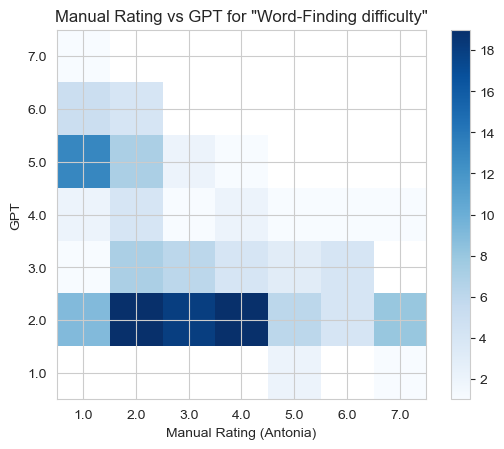

Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype='float64', name='Dafna')


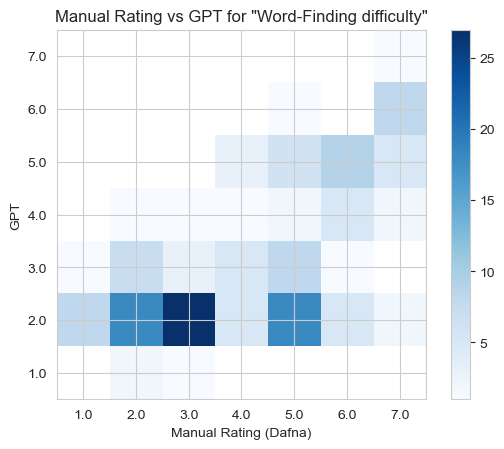

In [10]:
for rater in ['Antonia', 'Dafna']:
    counts = combined[[rater, 'gpt', 'sample_name']].groupby([rater, 'gpt']).count()
    pivoted = counts.reset_index().pivot(index=['gpt'], columns=[rater], values="sample_name")
    
    print(pivoted.columns)
    
    fig, ax = plt.subplots(1,1)
    mat = ax.imshow(pivoted, cmap='Blues')
    plt.colorbar(mat)
    ax.invert_yaxis()
    plt.xlabel(f"Manual Rating ({rater})")
    plt.ylabel("GPT")
    plt.xticks(range(len(pivoted.columns)), [m for m in pivoted.columns])
    plt.yticks(range(len(pivoted.index)), pivoted.index)
    plt.title(f'Manual Rating vs GPT for "Word-Finding difficulty"')
    plt.show()

In [11]:
combined['Antonia_normalized'] = 8-combined.Antonia
combined['diff'] = combined.Antonia_normalized - combined.gpt
combined.sort_values(by='diff', key=abs, ascending=False).head(10)

,sample_name,Antonia,Dafna,gpt,Antonia_normalized,diff
31,S040,1.0,2.0,2.0,7.0,5.0
51,S073,1.0,3.0,2.0,7.0,5.0
127,S179,1.0,7.0,2.0,7.0,5.0
6,S007,1.0,5.0,2.0,7.0,5.0
60,S086,1.0,5.0,2.0,7.0,5.0
72,S103,1.0,6.0,2.0,7.0,5.0
104,S151,1.0,5.0,2.0,7.0,5.0
101,S148,1.0,7.0,2.0,7.0,5.0
93,S138,1.0,6.0,2.0,7.0,5.0
78,S114,2.0,3.0,2.0,6.0,4.0


In [12]:
gpt_with_explanations = gpt.merge(explanations, on="sample_name", how="outer")


for idx, row in gpt_with_explanations[gpt_with_explanations.sample_name.isin(['S151', 'S148', 'S073', 'S179', 'S086', 'S103', ])].iterrows():
    print(row.sample_name, row.gpt, row['Word-Finding Difficulties (Anomia)_explanation'])


In [13]:
combined_long = combined.drop(columns=['diff', 'Antonia']).melt(id_vars=['sample_name'], var_name='rater', value_name='rating').sort_values(by='sample_name')
combined_long

,sample_name,rater,rating
0,S001,Dafna,3.0
312,S001,Antonia_normalized,2.0
156,S001,gpt,3.0
1,S002,Dafna,2.0
313,S002,Antonia_normalized,4.0
...,...,...,...
154,S206,Dafna,2.0
310,S206,gpt,2.0
311,S207,gpt,2.0
155,S207,Dafna,5.0


In [14]:
import pingouin as pg

all_icc = {}

icc = pg.intraclass_corr(data=combined_long[combined_long.rater.isin(['Antonia_normalized', 'Dafna'])], raters='rater', targets='sample_name', ratings='rating', nan_policy='omit')
icc#.query("Type == 'ICC3'").iloc[0,:].ICC


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.477293,2.826235,155,156,1.195468e-10,"[0.35, 0.59]"
1,ICC2,Single random raters,0.501844,3.483042,155,155,2.650050e-14,"[0.3, 0.65]"
2,ICC3,Single fixed raters,0.553874,3.483042,155,155,2.650050e-14,"[0.43, 0.65]"
3,ICC1k,Average raters absolute,0.646172,2.826235,155,156,1.195468e-10,"[0.51, 0.74]"
4,ICC2k,Average random raters,0.668304,3.483042,155,155,2.650050e-14,"[0.46, 0.78]"
5,ICC3k,Average fixed raters,0.712895,3.483042,155,155,2.650050e-14,"[0.61, 0.79]"


In [15]:
icc = pg.intraclass_corr(data=combined_long[combined_long.rater.isin(['gpt', 'Dafna'])], raters='rater', targets='sample_name', ratings='rating' ,nan_policy='omit')
icc#.query("Type == 'ICC3'").iloc[0,:].ICC


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.444886,2.602862,155,156,2.457739e-09,"[0.31, 0.56]"
1,ICC2,Single random raters,0.496516,4.127981,155,155,1.129284e-17,"[0.13, 0.7]"
2,ICC3,Single fixed raters,0.609983,4.127981,155,155,1.129284e-17,"[0.5, 0.7]"
3,ICC1k,Average raters absolute,0.615807,2.602862,155,156,2.457739e-09,"[0.47, 0.72]"
4,ICC2k,Average random raters,0.663563,4.127981,155,155,1.129284e-17,"[0.24, 0.82]"
5,ICC3k,Average fixed raters,0.757751,4.127981,155,155,1.129284e-17,"[0.67, 0.82]"


In [16]:
icc = pg.intraclass_corr(data=combined_long[combined_long.rater.isin(['gpt', 'Antonia_normalized'])], raters='rater', targets='sample_name', ratings='rating' ,nan_policy='omit')
icc#.query("Type == 'ICC3'").iloc[0,:].ICC


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.046038,1.096520,155,156,2.830948e-01,"[-0.11, 0.2]"
1,ICC2,Single random raters,0.246729,2.484001,155,155,1.335877e-08,"[-0.07, 0.5]"
2,ICC3,Single fixed raters,0.425947,2.484001,155,155,1.335877e-08,"[0.29, 0.55]"
3,ICC1k,Average raters absolute,0.088024,1.096520,155,156,2.830948e-01,"[-0.25, 0.33]"
4,ICC2k,Average random raters,0.395802,2.484001,155,155,1.335877e-08,"[-0.14, 0.67]"
5,ICC3k,Average fixed raters,0.597424,2.484001,155,155,1.335877e-08,"[0.45, 0.71]"


In [17]:
icc = pg.intraclass_corr(data=combined_long[combined_long.rater.isin(['gpt', 'Antonia_normalized', 'Dafna'])], raters='rater', targets='sample_name', ratings='rating' ,nan_policy='omit')
icc#.query("Type == 'ICC3K'").iloc[0,:].ICC


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.345523,2.583814,155,312,6.769406e-13,"[0.25, 0.45]"
1,ICC2,Single random raters,0.399873,4.417753,155,310,5.681083e-29,"[0.16, 0.58]"
2,ICC3,Single fixed raters,0.532547,4.417753,155,310,5.681083e-29,"[0.44, 0.62]"
3,ICC1k,Average raters absolute,0.612975,2.583814,155,312,6.769406e-13,"[0.49, 0.71]"
4,ICC2k,Average random raters,0.666549,4.417753,155,310,5.681083e-29,"[0.37, 0.81]"
5,ICC3k,Average fixed raters,0.773641,4.417753,155,310,5.681083e-29,"[0.7, 0.83]"
